In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.cluster import SpectralBiclustering
import numpy as np
import numba
from numba import jit
from sparsesvd import sparsesvd
from scipy.sparse import csc_matrix
!pip install -i https://test.pypi.org/simple/ ssvd-pkg-cathy10
from SSVD_pkg.algorithms import ssvd_original, ssvd_new

Looking in indexes: https://test.pypi.org/simple/


In [2]:
def ssvd_original(X, tol = 1e-3, lambda_us = None, lambda_vs = None, gamma1s = [2], gamma2s = [2], max_iter = 20, sparse_decomp = False):
    
    def BIC_v(lambda_v):
        v = abs(v_hat) - lambda_v*w2/2
        df = np.sum(v > 0)
        v[v <= 0] = 0
        v *= np.sign(v_hat)
        return (np.linalg.norm(X - u @ v.T)**2/sigma_sq_hat + np.log(nd)*df, v)
    
    def BIC_u(lambda_u):
        u = abs(u_hat) - lambda_u*w1/2
        df = np.sum(u > 0)
        u[u <= 0] = 0
        u *= np.sign(u_hat)
        return (np.linalg.norm(X - u @ v.T)**2/sigma_sq_hat + np.log(nd)*df, u)
    
    if sparse_decomp:
        u, s, v = sparsesvd(csc_matrix(X), 1)
        u = u.reshape(-1,1)
        s = s[0]
        v = v.reshape(-1,1)
    else:
        U, S, V = np.linalg.svd(X, full_matrices = False)
        u = U[:,0][:,None]
        v = V[0,:][:,None]
        s = S[0]
    n, d = X.shape
    nd = n*d
    iter_num = 0
    is_lambda_us_given = lambda_us is not None
    is_lambda_vs_given = lambda_vs is not None
    
    while iter_num < max_iter:
        
        # Update v
        v_hat = X.T @ u
        if all(v_hat == 0):
            v_new = v_hat
        else:
            sigma_sq_hat = np.linalg.norm(X - u @ v_hat.T)**2/(nd-d)
            min_BIC_val = float('inf')
            for gamma2 in gamma2s:
                w2 = np.abs(v_hat)**-gamma2
                if not is_lambda_vs_given:
                    lambda_vs = abs(v_hat)*2/w2
                BIC_vals, v_vals = list(zip(*list(map(BIC_v, lambda_vs))))
                if np.min(BIC_vals) < min_BIC_val:
                    min_BIC_val = np.min(BIC_vals)
                    v_new = v_vals[np.argmin(BIC_vals)]
                    if not all(v_new == 0):
                        v_new = v_new/np.linalg.norm(v_new)
        delta_v_norm = np.linalg.norm(v_new - v)
        v = v_new
        
        # Update u
        u_hat = X @ v
        if all(u_hat == 0):
            u_new = u_hat
        else:
            sigma_sq_hat = np.linalg.norm(X - u_hat @ v.T)**2/(nd-n)
            min_BIC_val = float('inf')
            for gamma1 in gamma1s:
                w1 = np.abs(u_hat)**-gamma1
                if not is_lambda_us_given:
                    lambda_us = abs(u_hat)*2/w1
                BIC_vals, u_vals = list(zip(*list(map(BIC_u, lambda_us))))
                if np.min(BIC_vals) < min_BIC_val:
                    min_BIC_val = np.min(BIC_vals)
                    u_new = u_vals[np.argmin(BIC_vals)]
                    if not all (u_new == 0):
                        u_new = u_new/np.linalg.norm(u_new)
        delta_u_norm = np.linalg.norm(u_new - u)
        u = u_new
        
        iter_num += 1
    
        if (delta_v_norm < tol) and (delta_u_norm < tol):
            break
    
    if (delta_v_norm >= tol) or (delta_u_norm >= tol):
        print("Failed to converge in {} iterations. Try increasing tolerance, or increasing the maximum number of iterations.".format(iter_num))
    
    return u, v, (u.T @ X @ v)[0][0]

In [3]:
@jit(nopython=True)
def BIC_v(lambda_v, v_hat, w2, u, sigma_sq_hat, nd, X):
    v = np.abs(v_hat) - lambda_v*w2/2
    df = np.sum(v > 0)
    
    vcopy = v.ravel()
    
    for i in range(vcopy.shape[0]):
        if vcopy[i] <= 0:
            vcopy[i] = 0
    v = vcopy.reshape(v.shape)
    
    v *= np.sign(v_hat)
    return (np.linalg.norm(X - u @ v.T)**2/sigma_sq_hat + np.log(nd)*df, v)

@jit(nopython=True)
def BIC_u(lambda_u, u_hat, w1, v, sigma_sq_hat, nd, X):
    u = np.abs(u_hat) - lambda_u*w1/2
    df = np.sum(u > 0)
    
    ucopy = u.ravel()
    for i in range(ucopy.shape[0]):
        if ucopy[i] <= 0:
            ucopy[i] = 0
    u = ucopy.reshape(u.shape)

    u *= np.sign(u_hat)
    return (np.linalg.norm(X - u @ v.T)**2/sigma_sq_hat + np.log(nd)*df, u)

@jit(nopython=True)
def ssvd_new(X, BIC_v = BIC_v, BIC_u = BIC_u, tol = 1e-3, lambda_us = None, lambda_vs = None, gamma1s=None, gamma2s=None, max_iter = 20):
    
    if gamma1s is None:
        gamma1s = [2]
    
    if gamma2s is None:
        gamma2s = [2]
    
    U, S, V = np.linalg.svd(X, full_matrices = False)
    u = U[:,0].copy()
    u = u.reshape((u.shape[0],1))
    v = V[0,:].copy()
    v = v.reshape((v.shape[0],1))
    s = S[0]
    n, d = X.shape
    nd = n*d
    iter_num = 0
    is_lambda_us_given = lambda_us is not None
    is_lambda_vs_given = lambda_vs is not None
   
    while iter_num < max_iter:
        
        # Update v
        v_hat = X.T @ u
    
        if not v_hat.any():
            v_new = v_hat
            
        else:
            sigma_sq_hat = np.linalg.norm(X - u @ v_hat.T)**2/(nd-d)
            min_BIC_val = 1e8 
            for gamma2 in gamma2s:
                w2 = np.abs(v_hat)**-gamma2
                if not is_lambda_vs_given:
                    lambda_vs = np.abs(v_hat)*2/w2
  
                BIC_vals_lst=[0.]*lambda_vs.shape[0]
                v_vals=[np.zeros((lambda_vs.shape[0],1))]*lambda_vs.shape[0]
                for i in range(lambda_vs.shape[0]):
                    bic_val, v_val = BIC_v(lambda_v=lambda_vs[i,0], v_hat=v_hat, w2=w2, u=u, sigma_sq_hat=sigma_sq_hat, nd=nd, X=X)
                    BIC_vals_lst[i] = bic_val
                    v_vals[i] = v_val
                
                BIC_vals = np.array(BIC_vals_lst)
                if np.min(BIC_vals) < min_BIC_val:
                    min_BIC_val = np.min(BIC_vals)
                    v_new = v_vals[np.argmin(BIC_vals)]
                    
                    if v_new.any():
                        v_new = v_new/np.linalg.norm(v_new)
        delta_v_norm = np.linalg.norm(v_new - v)
        v = v_new
        
        # Update u
        u_hat = X @ v
        
        if not u_hat.any():
            u_new = u_hat
        else:
            sigma_sq_hat = np.linalg.norm(X - u_hat @ v.T)**2/(nd-n)
            min_BIC_val = 1e8 
            for gamma1 in gamma1s:
                w1 = np.abs(u_hat)**-gamma1
                if not is_lambda_us_given:
                    lambda_us = np.abs(u_hat)*2/w1
            
                BIC_vals_lst=[0.]*lambda_us.shape[0]
                u_vals=[np.zeros((lambda_us.shape[0],1))]*lambda_us.shape[0]
                for i in range(lambda_us.shape[0]):
                    bic_val, u_val = BIC_u(lambda_u = lambda_us[i,0], u_hat=u_hat, w1=w1, v=v, sigma_sq_hat=sigma_sq_hat, nd=nd, X=X)
                    BIC_vals_lst[i] = bic_val
                    u_vals[i] = u_val
                    
                BIC_vals = np.array(BIC_vals_lst)
                if np.min(BIC_vals) < min_BIC_val:
                    min_BIC_val = np.min(BIC_vals)
                    u_new = u_vals[np.argmin(BIC_vals)]
                  
                    if u_new.any():
                        u_new = u_new/np.linalg.norm(u_new)
        delta_u_norm = np.linalg.norm(u_new - u)
        u = u_new
        
        iter_num += 1
    
        if (delta_v_norm < tol) and (delta_u_norm < tol):
            break
    
    if (delta_v_norm >= tol) or (delta_u_norm >= tol):
        
        print("Failed to converge in", iter_num, "iterations. Try increasing tolerance, or increasing the maximum number of iterations.")
    
    return u, v, (u.T @ X @ v)[0][0]

# Simulation 1 - Rank 1 Approximation

In [4]:
u_tilde = np.concatenate((np.arange(10,2,-1), 2*np.ones(17), np.zeros(75)))[:,None]
u_true = u_tilde/np.linalg.norm(u_tilde)
v_tilde = np.concatenate((np.array([10, -10, 8, -8, 5, -5]), 3*np.ones(5), -3*np.ones(5), np.zeros(34)))[:,None]
v_true = v_tilde/np.linalg.norm(v_tilde)
X_star = 50*u_true*v_true.T
n, d = X_star.shape
np.random.seed(0)
nsims = 100
sims = np.empty((nsims, n, d))
for i in range(nsims):
    sims[i] = X_star + np.random.randn(n, d)

In [5]:
u_true_labels = u_true == 0
v_true_labels = v_true == 0

## Optimization

In [6]:
ssvd_u_preds_original, ssvd_v_preds_original, ssvd_s_values_original = list(zip(*list(map(ssvd_original, sims))))

In [7]:
print("SSVD Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), ssvd_u_preds_original)))*100))
print("SSVD Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), ssvd_v_preds_original)))*100))

SSVD Misclassification rate for u is 1.27%
SSVD Misclassification rate for v is 0.28%


In [8]:
ssvd_u_preds_sparsesvd, ssvd_v_preds_sparsesvd, ssvd_s_values_sparsesvd = list(zip(*list(map(lambda x : ssvd_original(x, sparse_decomp = True), sims))))

In [9]:
print("SSVD Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), ssvd_u_preds_sparsesvd)))*100))
print("SSVD Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), ssvd_v_preds_sparsesvd)))*100))

SSVD Misclassification rate for u is 1.27%
SSVD Misclassification rate for v is 0.28%


In [10]:
ssvd_u_preds, ssvd_v_preds, ssvd_s_values = list(zip(*list(map(ssvd_new, sims))))

In [11]:
print("SSVD Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), ssvd_u_preds)))*100))
print("SSVD Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), ssvd_v_preds)))*100))

SSVD Misclassification rate for u is 1.27%
SSVD Misclassification rate for v is 0.28%


In [12]:
# Ensure that the signs of the singular vectors are the same, for comparison
print(np.allclose(tuple(map(lambda x : -x if x[0] < 0 else x, ssvd_u_preds_original)), 
                  tuple(map(lambda x : -x if x[0] < 0 else x, ssvd_u_preds_sparsesvd)), atol = 1e-1))
print(np.allclose(tuple(map(lambda x : -x if x[0] < 0 else x, ssvd_v_preds_original)), 
                  tuple(map(lambda x : -x if x[0] < 0 else x, ssvd_v_preds_sparsesvd)), atol = 1e-1))
print(np.allclose(ssvd_s_values_original, ssvd_s_values_sparsesvd, atol = 1e-4))

print(np.allclose(ssvd_u_preds_original, ssvd_u_preds, atol = 1e-4))
print(np.allclose(ssvd_v_preds_original, ssvd_v_preds, atol = 1e-4))
print(np.allclose(ssvd_s_values_original, ssvd_s_values, atol = 1e-4))

True
True
True
True
True
True


In [13]:
%%timeit
ssvd_u_preds_original, ssvd_v_preds_original, ssvd_s_values_original = list(zip(*list(map(ssvd_original, sims))))

2.87 s ± 227 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
ssvd_u_preds_sparsesvd, ssvd_v_preds_sparsesvd, ssvd_s_values_sparsesvd = list(zip(*list(map(lambda x : ssvd_original(x, sparse_decomp = True), sims))))

2.49 s ± 142 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit
ssvd_u_preds, ssvd_v_preds, ssvd_s_values = list(zip(*list(map(ssvd_new, sims))))

711 ms ± 44.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Comparison with other algorithms

### SVD

In [16]:
svd_u_preds, svd_v_preds = list(zip(*list(map(lambda x : (x[0][:,0][:,None], x[2][0,:][:,None]), map(lambda x : np.linalg.svd(x, full_matrices = False), sims)))))

In [17]:
print("SVD Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), svd_u_preds)))*100))
print("SVD Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), svd_v_preds)))*100))

SVD Misclassification rate for u is 75.00%
SVD Misclassification rate for v is 68.00%


### Spectral Clustering

In [18]:
sc_u_preds, sc_v_preds = list(zip(*list(map(lambda x : (x.row_labels_, x.column_labels_), map(lambda x : SpectralBiclustering(n_clusters=2, random_state=0).fit(x), sims)))))

In [19]:
sc_u_wrong = np.mean(list(map(lambda x : min(np.mean((x == 0) != u_true_labels), np.mean((x == 1) != u_true_labels)), sc_u_preds)))*100
sc_v_wrong = np.mean(list(map(lambda x : min(np.mean((x == 0) != v_true_labels), np.mean((x == 1) != v_true_labels)), sc_v_preds)))*100
print("Spectral Clusting Misclassification rate for u is {0:.2f}%".format(sc_u_wrong))
print("Spectral Clusting Misclassification rate for v is {0:.2f}%".format(sc_v_wrong))

Spectral Clusting Misclassification rate for u is 47.11%
Spectral Clusting Misclassification rate for v is 37.74%


# Simulation 2 - Higher Rank Approximation

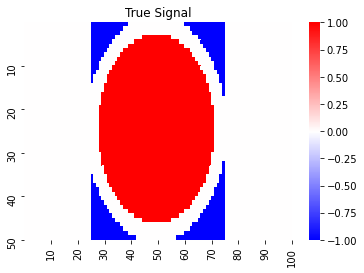

In [20]:
X_star = np.fromfunction(lambda i, j: np.where((25 <= j) & (j <= 74), (24**2 - (i+1-25)**2 - (j+1-50)**2)/100, 0), (50,100)) # like ternary
X_star *= (np.abs(X_star) > 1)
ax = sns.heatmap(X_star, vmin = -1, vmax = 1, cmap = 'bwr')
ax.set_title("True Signal");
xticks = np.arange(10,110,10)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
yticks = np.arange(10,60,10)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks);

In [21]:
nsims = 100
n, d = X_star.shape
sims = np.empty((nsims, n, d))
for i in range(nsims):
    sims[i] = X_star + np.random.randn(n, d)

## Comparison with other algorithms

In [22]:
sims_copy = copy.deepcopy(sims)
layers = 8
ssvd_estimates = np.empty((layers, nsims, n, d))
for i in range(layers):
    # Failure of convergence is expected at high number of layers, given that most information is already extracted by then.
    ssvd_predictions = np.array(list(map(lambda x : x[2] * x[0] @ x[1].T, map(lambda x : ssvd_new(x, tol = 1e-3, max_iter = 40), sims_copy))))
    ssvd_estimates[i] = ssvd_predictions
    sims_copy -= ssvd_predictions

In [23]:
svd_decomps = list(map(lambda x : np.linalg.svd(x, full_matrices = False), sims_copy))
svd_estimates = np.empty((layers, nsims, n, d))
for i in range(layers):
    svd_estimates[i] = np.array(list(map(lambda x : x[1][i] * x[0][:,i][:,None] @ x[2][i,:][None,:],svd_decomps)))

In [24]:
for i in range(1, layers):
    ssvd_estimates[i] += ssvd_estimates[i-1]
    svd_estimates[i] += svd_estimates[i-1]

In [25]:
ssvd_classification = []
svd_classification = []
X_star_labels = X_star == 0
for i in range(layers):
    ssvd_classification.append(np.mean(list((map(lambda x : np.mean((x == 0) == X_star_labels), ssvd_estimates[i])))))
    svd_classification.append(np.mean(list((map(lambda x : np.mean((x == 0) == X_star_labels), svd_estimates[i])))))

In [26]:
max_equal = lambda x : max(np.mean(x == (X_star == 0)), np.mean(x == (X_star != 0)))
sc_classification = list(map(lambda num_layers : 
                             np.mean(list(map(lambda x : max(max_equal(x.row_labels_[:, None] @ x.column_labels_[None, :]),
                                                             max_equal((x.row_labels_[:, None] == 0) @ x.column_labels_[None, :]), 
                                                             max_equal(x.row_labels_[:, None] @ (x.column_labels_[None, :] == 0)), 
                                                             max_equal((x.row_labels_[:, None] == 0) @ (x.column_labels_[None, :] == 0))), 
                                              map(lambda x : SpectralBiclustering(n_clusters=2, random_state=0, n_components = num_layers, n_best = min(3, num_layers)).fit(x), sims)))), np.arange(1,9)))

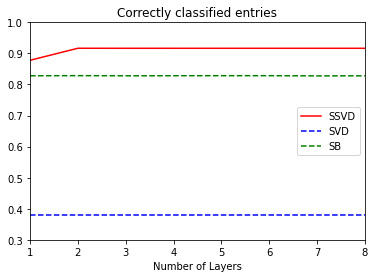

In [27]:
plt.plot(np.arange(1,9), ssvd_classification, label = "SSVD", color = "red")
plt.plot(np.arange(1,9), svd_classification, label = "SVD", color = "blue", linestyle = "dashed")
plt.plot(np.arange(1,9), sc_classification, label = "SB", color = "green", linestyle = "dashed")
plt.xlabel("Number of Layers")
plt.ylim([0.3, 1])
plt.xlim([1, 8])
plt.title("Correctly classified entries")
plt.legend();

# Real Dataset 1 - Lung Cancer Data (In Paper)

## Optimization

Since this takes a long time, we only time how long it takes to extract the first SSVD layer.

In [28]:
X_lung = np.loadtxt('lungcancerdata.txt', delimiter = ' ').T

In [29]:
%%time
u1_original, v1_original, s1_original = ssvd_original(X_lung)

CPU times: user 10min 19s, sys: 2min 41s, total: 13min 1s
Wall time: 7min 7s


In [30]:
X_lung = np.loadtxt('lungcancerdata.txt', delimiter = ' ').T

In [31]:
%%time
u1_sparsesvd, v1_sparsesvd, s1_sparsesvd = ssvd_original(X_lung, sparse_decomp = True)

CPU times: user 10min 21s, sys: 2min 33s, total: 12min 54s
Wall time: 7min 39s


In [32]:
X_lung = np.loadtxt('lungcancerdata.txt', delimiter = ' ').T

In [33]:
%%time
u1, v1, s1 = ssvd_new(X_lung)

CPU times: user 9min 26s, sys: 2min 15s, total: 11min 42s
Wall time: 6min 46s


In [34]:
print(np.allclose(np.r_[u1_original, v1_original, np.array([s1_original])[:, None]], 
                  np.r_[u1, v1, np.array([s1])[:, None]], atol = 1e-5))

print(np.allclose(np.r_[u1_sparsesvd, v1_sparsesvd, np.array([s1_sparsesvd])[:, None]], 
                  np.r_[u1, v1, np.array([s1])[:, None]], atol = 1e-5))

True
True


In [35]:
X_lung -= s1*(u1 @ v1.T)
u2, v2, s2 = ssvd_new(X_lung)
X_lung -= s2*(u2 @ v2.T)
u3, v3, s3 = ssvd_original(X_lung)

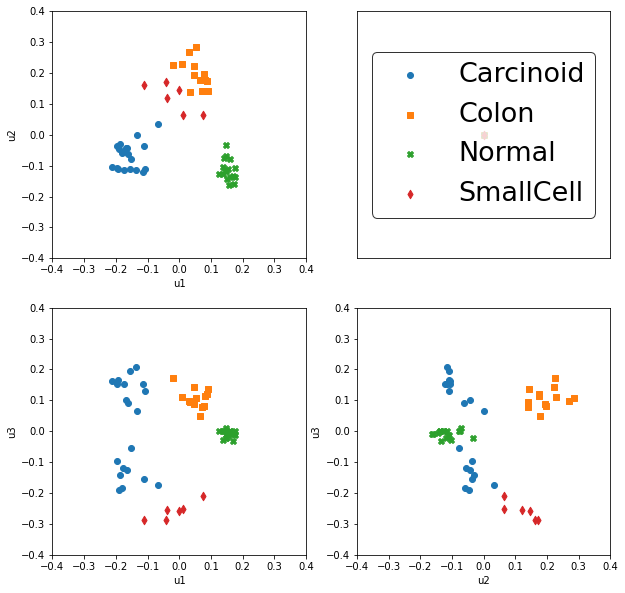

In [36]:
group_indices = [np.arange(20), np.arange(20,33), np.arange(33,50), np.arange(50,56)]
markers = ["o", "s", "X", "d"]
labels = ["Carcinoid", "Colon", "Normal", "SmallCell"]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for row in axs:
    for ax in row:
        ax.set_xlim([-0.4, 0.4])
        ax.set_ylim([-0.4, 0.4])
for i in range(len(group_indices)):
    group = group_indices[i]
    axs[0,0].scatter(u1[group], u2[group], marker = markers[i])
    axs[1,0].scatter(u1[group], u3[group], marker = markers[i])
    axs[1,1].scatter(u2[group], u3[group], marker = markers[i])
    axs[0,1].scatter(0, 0, marker = markers[i], label = labels[i])
axs[0,1].legend(loc = 10, fontsize=27).get_frame().set_edgecolor('black')
axs[0,0].set_xlabel("u1")
axs[1,0].set_xlabel("u1")
axs[1,1].set_xlabel("u2")
axs[0,0].set_ylabel("u2")
axs[1,0].set_ylabel("u3")
axs[1,1].set_ylabel("u3")
axs[0,1].set_yticks(()) 
axs[0,1].set_xticks(());

In [37]:
def get_X_for_plotting(u, v, s):
    group_indices = [np.arange(20), np.arange(20,33), np.arange(33,50), np.arange(50,56)]
    for group in group_indices:
        u[group] = np.sort(u[group], axis = 0)

    v_nonzero = v[np.argsort(np.abs(v), axis = 0)[8000:].flatten()]
    v = np.sort(v_nonzero, axis = 0)
    return s * u @ v.T

In [38]:
X1 = get_X_for_plotting(u1, v1, s1)
X2 = get_X_for_plotting(u2, v2, s2)
X3 = get_X_for_plotting(u3, v3, s3)
max_val = np.max(np.abs(np.c_[X1,X2,X3]))
# rescale for increased contrast due to differing colormap
rescale = 3
X1 /= max_val/rescale
X2 /= max_val/rescale
X3 /= max_val/rescale

In [39]:
def plot_lung(X, title, xticks, ax_given, cbar_ax, yticklabels):
    ax = sns.heatmap(X, vmin = -1, vmax = 1, cmap = 'bwr', ax = ax_given, cbar_ax = cbar_ax)
    ax.hlines([20, 33, 50], *ax.get_xlim(), linestyle=':', color = 'sienna')
    ax.vlines([xticks[0], xticks[1]-8000], *ax.get_xlim(), linestyle=':', color = 'sienna')
    ax.set_xticks((xticks[0], xticks[1]-8000)) 
    ax.set_xticklabels((str(xticks[0]), str(xticks[1])), rotation = 0)
    ax.set_yticks((10, 27, 42, 53)) 
    ax.set_yticklabels(yticklabels) 
    ax.set_title(title)
    ax.set_xlabel("Ordered gene index");

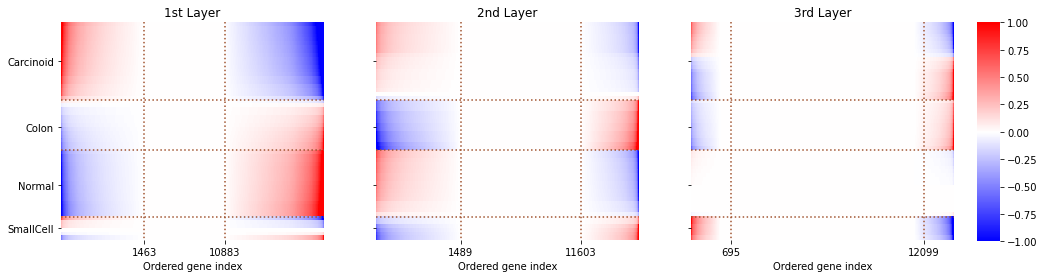

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))
cbar_ax = fig.add_axes([.92, .12, .02, 0.76])
plot_lung(X1, "1st Layer", [1463, 10883], ax1, cbar_ax, ("Carcinoid", "Colon", "Normal", "SmallCell"))
plot_lung(X2, "2nd Layer", [1489, 11603], ax2, cbar_ax, ())
plot_lung(X3, "3rd Layer", [695, 12099], ax3, cbar_ax, ())

# Real Dataset 2 - Company Financial Fraud Data (Not In Paper)

In [41]:
X_com = np.loadtxt('companyfraud.txt')
X_com = np.abs(np.cos(np.array(X_com*180)))

In [42]:
%%timeit
u1, v1, s1 = ssvd_original(X_com)
X_com2 = X_com - s1*(u1 @ v1.T)
u2, v2, s2 = ssvd_original(X_com2)
X_com3 = X_com2 - s2*(u2 @ v2.T)
u3, v3, s3 = ssvd_original(X_com)

38.6 ms ± 513 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
X_com = np.loadtxt('companyfraud.txt')
X_com = np.abs(np.cos(np.array(X_com*180)))
u1_original, v1_original, s1_original = ssvd_original(X_com)
X_com2 = X_com - s1_original*(u1_original @ v1_original.T)
u2_original, v2_original, s2_original = ssvd_original(X_com2)
X_com3 = X_com2 - s2_original*(u2_original @ v2_original.T)
u3_original, v3_original, s3_original = ssvd_original(X_com3)

In [44]:
X_com = np.loadtxt('companyfraud.txt')
X_com = np.abs(np.cos(np.array(X_com*180)))

In [45]:
%%timeit
u1, v1, s1 = ssvd_original(X_com, sparse_decomp = True)
X_com2 = X_com - s1*(u1 @ v1.T)
u2, v2, s2 = ssvd_original(X_com2, sparse_decomp = True)
X_com3 = X_com2 - s2*(u2 @ v2.T)
u3, v3, s3 = ssvd_original(X_com3, sparse_decomp = True)

40.8 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
X_com = np.loadtxt('companyfraud.txt')
X_com = np.abs(np.cos(np.array(X_com*180)))
u1_sparsesvd, v1_sparsesvd, s1_sparsesvd = ssvd_original(X_com, sparse_decomp = True)
X_com2 = X_com - s1_sparsesvd*(u1_sparsesvd @ v1_sparsesvd.T)
u2_sparsesvd, v2_sparsesvd, s2_sparsesvd = ssvd_original(X_com2, sparse_decomp = True)
X_com3 = X_com2 - s2_sparsesvd*(u2_sparsesvd @ v2_sparsesvd.T)
u3_sparsesvd, v3_sparsesvd, s3_sparsesvd = ssvd_original(X_com3, sparse_decomp = True)

In [47]:
X_com = np.loadtxt('companyfraud.txt')
X_com = np.abs(np.cos(np.array(X_com*180)))

In [48]:
%%timeit
u1, v1, s1 = ssvd_new(X_com)
X_com2 = X_com - s1*(u1 @ v1.T)
u2, v2, s2 = ssvd_new(X_com2)
X_com3 = X_com2 - s2*(u2 @ v2.T)
u3, v3, s3 = ssvd_new(X_com3)

4.79 ms ± 89.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
X_com = np.loadtxt('companyfraud.txt')
X_com = np.abs(np.cos(np.array(X_com*180)))
u1, v1, s1 = ssvd_new(X_com)
X_com2 = X_com - s1*(u1 @ v1.T)
u2, v2, s2 = ssvd_new(X_com2)
X_com3 = X_com2 - s2*(u2 @ v2.T)
u3, v3, s3 = ssvd_new(X_com3)

In [50]:
print(np.allclose(np.r_[u1_original, v1_original, np.array([s1_original])[:, None]], 
                  np.r_[u1, v1, np.array([s1])[:, None]], atol = 1e-4))
print(np.allclose(np.r_[u2_original, v2_original, np.array([s2_original])[:, None]], 
                  np.r_[u2, v2, np.array([s2])[:, None]], atol = 1e-4))
print(np.allclose(np.r_[u3_original, v3_original, np.array([s3_original])[:, None]], 
                  np.r_[u3, v3, np.array([s3])[:, None]], atol = 1e-3))

print(np.allclose(np.r_[u1_sparsesvd, v1_sparsesvd, np.array([s1_sparsesvd])[:, None]], 
                  np.r_[u1, v1, np.array([s1])[:, None]], atol = 1e-4))
print(np.allclose(np.r_[u2_sparsesvd, v2_sparsesvd, np.array([s2_sparsesvd])[:, None]], 
                  np.r_[-u2, -v2, np.array([s2])[:, None]], atol = 1e-4))
print(np.allclose(np.r_[u3_sparsesvd, v3_sparsesvd, np.array([s3_sparsesvd])[:, None]], 
                  np.r_[-u3, -v3, np.array([s3])[:, None]], atol = 1e-3))

True
True
True
True
True
True


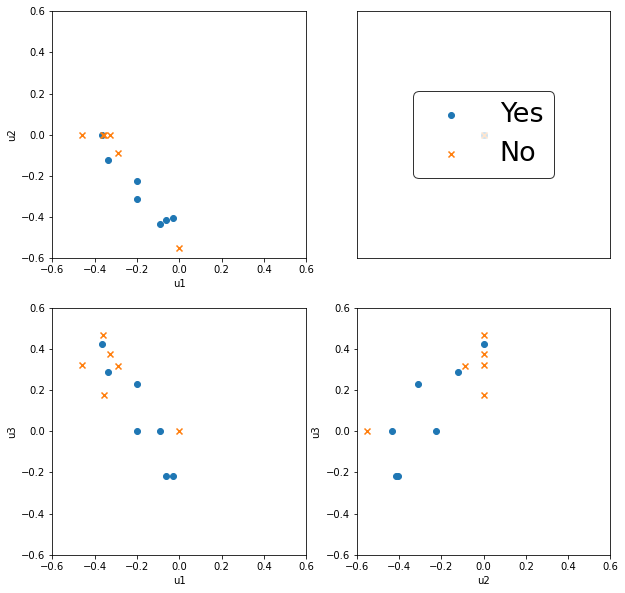

In [51]:
group_indices = [np.arange(7), np.arange(7,13)]
markers = ["o", "x"]
labels = ["Yes", "No"]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for row in axs:
    for ax in row:
        ax.set_xlim([-0.6, 0.6])
        ax.set_ylim([-0.6, 0.6])
for i in range(len(group_indices)):
    group = group_indices[i]
    axs[0,0].scatter(u1[group], u2[group], marker = markers[i])
    axs[1,0].scatter(u1[group], u3[group], marker = markers[i])
    axs[1,1].scatter(u2[group], u3[group], marker = markers[i])
    axs[0,1].scatter(0, 0, marker = markers[i], label = labels[i])
axs[0,1].legend(loc = 10, fontsize=27).get_frame().set_edgecolor('black')
axs[0,0].set_xlabel("u1")
axs[1,0].set_xlabel("u1")
axs[1,1].set_xlabel("u2")
axs[0,0].set_ylabel("u2")
axs[1,0].set_ylabel("u3")
axs[1,1].set_ylabel("u3")
axs[0,1].set_yticks(()) 
axs[0,1].set_xticks(());

In [52]:
def get_X_for_plotting(u, v, s):
    group_indices = [np.arange(7), np.arange(7,13)]
    for group in group_indices:
        u[group] = np.sort(u[group], axis = 0)

    v_nonzero = v[np.argsort(np.abs(v), axis = 0).flatten()]
    v = np.sort(v_nonzero, axis = 0)
    return s * u @ v.T

In [53]:
X1 = get_X_for_plotting(u1, v1, s1)
X2 = get_X_for_plotting(u2, v2, s2)
X3 = get_X_for_plotting(u3, v3, s3)
max_val = np.max(np.abs(np.c_[X1,X2,X3]))
# rescale for increased contrast due to differing colormap
rescale = 3
X1 /= max_val/rescale
X2 /= max_val/rescale
X3 /= max_val/rescale

In [54]:
def plot_comp(X, title, ax_given, cbar_ax, yticklabels):
    ax = sns.heatmap(X, vmin = -1, vmax = 1, cmap = 'bwr', ax = ax_given, cbar_ax = cbar_ax)
    ax.hlines([13], *ax.get_xlim(), linestyle=':', color = 'sienna')
    ax.set_yticks([7.5, 22]) 
    ax.set_ylim([-5, 30])
    ax.set_yticklabels(yticklabels) 
    ax.set_title(title)
    ax.set_xlabel("Evaluation Index");

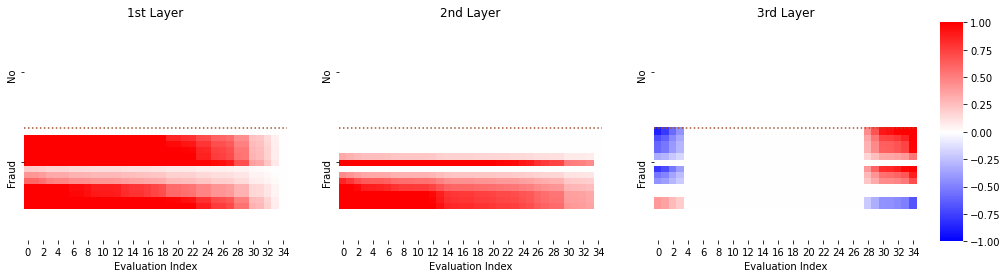

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))
cbar_ax = fig.add_axes([.92, .12, .02, 0.76])
plot_comp(X1, "1st Layer", ax1, cbar_ax, ("Fraud", "No"))
plot_comp(X2, "2nd Layer", ax2, cbar_ax, ("Fraud", "No"))
plot_comp(X3, "3rd Layer", ax3, cbar_ax, ("Fraud", "No"))